In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
from matplotlib import pyplot as plt
import os
import gc
from load_dataset import  get_orth_dataloader
import utils
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import shutil
from IPython.display import clear_output




c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_matrices = joblib.load('data/AA_random_matrices.joblib')

In [3]:
train, test = get_orth_dataloader('AA_orth3.joblib',shuffle=False, train_size=0.8, batch_size=64)


In [22]:
class Encoder(nn.Module):
    def __init__(self, out_dim, in_channels, latent_dim, conv_k=3, conv_s=1, conv_p=1, pool_k=0, pool_s=1,
                 use_batch_norm=False, dropout_rate=0, activation_function=nn.ReLU):
        super().__init__()
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s
        self.in_channels = in_channels
        self.use_batch_norm = use_batch_norm
        self.layers = nn.ModuleList()
        self.conv_out_height,  self.conv_out_width = out_dim

        for i in range(len(self.in_channels) - 1):
            self.layers.append(nn.Conv2d(self.in_channels[i], self.in_channels[i + 1],
                                         kernel_size=self.conv_k, stride=self.conv_s, padding=self.conv_p))
            self.layers.append(activation_function())
            if use_batch_norm:
                self.layers.append(nn.BatchNorm2d(self.in_channels[i + 1]))
            
            self.layers.append(nn.Dropout2d(p=dropout_rate))
            self.conv_out_height = self.compute_dim(self.conv_out_height, conv_k, conv_s, conv_p, pool_k, pool_s)
            self.conv_out_width = self.compute_dim(self.conv_out_width, conv_k, conv_s, conv_p, pool_k, pool_s)

        self.conv_net = nn.Sequential(*self.layers)
        self.fc = nn.Linear(int( self.conv_out_height* self.conv_out_width* self.in_channels[-1]), latent_dim)

    def compute_dim(self, dim, conv_k, conv_s, conv_p, pool_k, pool_s):
        return np.floor(((dim - conv_k + 2 *conv_p)/conv_s)+1)
        # return np.floor(((dim - pool_k)/pool_s)+1)
    
    def forward(self, x):
        out = self.conv_net(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [5]:
class Decoder(nn.Module):
    def __init__(self, out_dim, in_channels, latent_dim, conv_k=3, conv_s=1, conv_p=1, pool_k=2, pool_s=2,
                 use_batch_norm=False, dropout_rate=0, activation_function=nn.ReLU):
        super().__init__()
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s

        self.in_channels = in_channels
        self.layers = nn.ModuleList()
        self.latent_dim = latent_dim
        

        for i in range(len(self.in_channels) - 1):
            self.layers.append(nn.ConvTranspose2d(self.in_channels[i], self.in_channels[i + 1],
                                                  kernel_size=self.conv_k, stride=self.conv_s, padding=self.conv_p))
            self.layers.append(activation_function())
            if use_batch_norm:
                self.layers.append(nn.BatchNorm2d(self.in_channels[i + 1]))
            self.layers.append(nn.Dropout2d(p=dropout_rate))

        self.layers.append(nn.Tanh())
        self.conv_net = nn.Sequential(*self.layers)
        self.fc = nn.Linear(latent_dim, int(out_dim * in_channels[0] * (pool_s ** 2)))

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], self.in_channels[0], self.pool_s, self.pool_s)
        x = self.conv_net(x)
        return x


In [6]:
class Autoencoder(pl.LightningModule):
    def __init__(
        self,
        data_shape: tuple,
        in_channels,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        conv_k = 3, conv_s=1, conv_p=1, pool_k=0, pool_s=1,
        use_batch_norm=False, dropout_rate = 0,
        activation_function = nn.ReLU, optimizer = optim.Adagrad, loss_func = nn.MSELoss(), lr= 0.0001
    ):
        super().__init__()

        self.in_channels = in_channels
        self.lr = lr
        self.data_shape = data_shape
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.activation_function = activation_function
        out_dim = data_shape[1]

        for _ in range(len(in_channels)-1):
            out_dim = self.compute_dim(out_dim, self.conv_k, self.conv_s, self.conv_p, self.pool_k, self.pool_s)

        in_channels_reversed = in_channels[::-1]
        self.encoder = encoder_class(out_dim, in_channels, latent_dim, conv_k, conv_s, conv_p, pool_k, pool_s, use_batch_norm, dropout_rate, activation_function)
        self.decoder = decoder_class(out_dim, in_channels_reversed, latent_dim, conv_k, conv_s, conv_p, pool_k, pool_s, use_batch_norm, dropout_rate, activation_function)
        self.out_dim = out_dim

        self.training_epoch_mean = []
        self.current_training_epoch_loss = []
        self.training_step_loss = []
        self.validation_epoch_mean = []
        self.current_validation_epoch_loss = []
        self.validation_step_loss = []
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x,_ = batch  # We do not need the labels
        preds = self.forward(x)
        loss = self.loss_func(preds, x)
        return loss

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.current_training_epoch_loss.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.current_validation_epoch_loss.append(loss.detach().cpu().numpy())

    def on_train_epoch_end(self):
        epoch_loss = np.mean(self.current_training_epoch_loss)
        self.training_step_loss += self.current_training_epoch_loss
        self.training_epoch_mean.append(epoch_loss)
        self.log("train_epoch_loss", epoch_loss, prog_bar=True)
        self.current_training_epoch_loss.clear()

    def on_validation_epoch_end(self):
        epoch_loss = np.mean(self.current_validation_epoch_loss)
        self.validation_step_loss += self.current_validation_epoch_loss
        self.validation_epoch_mean.append(epoch_loss)
        self.log("validation_epoch_loss", epoch_loss, prog_bar=True)
        self.current_validation_epoch_loss.clear()

    def compute_dim(self, dim, conv_k, conv_s, conv_p, pool_k, pool_s):
        dim = np.floor(((dim - conv_k + 2 * conv_p)/conv_s)+1)
        return dim

In [8]:
config = {
    'output_shape': [(1965,22)],
    'epochs': [30],
    'latent_dim':[64,128,256,512,1024],
    'channels':[[1965,512,256,128], [1965,512,256], [1965,512,256,128,64]],
    # 'conv_k': range(2,5),
    # 'conv_s': range(0,2),
    # 'conv_p': range(0,2),
    # 'pool_k': range(2,4),
    # 'pool_s': range(0,2),
    'activation_func': [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU],
    'loss_func': [nn.MSELoss(), nn.L1Loss()],
    'optimizer' : [optim.SGD, optim.Adagrad, optim.AdamW],
    'dropout_rate' : [0, 0.25],
    'batch_normalization' : [True, False]
}


In [9]:
torch.set_float32_matmul_precision('medium')
for conf in utils.get_combinations(config):
    clear_output(wait=True)

    file_name = '{}_{}_{}_{}_{}_{}_{}'.format(
                            conf["channels"], conf['latent_dim'], conf["activation_func"].__name__,
                            conf["optimizer"].__name__, conf["loss_func"].__class__.__name__, conf["dropout_rate"], conf["batch_normalization"],
                            )
    if file_name not in os.listdir('models/Autoencoder2D/'):
        gc.collect()
        print(conf)
        early_stopping = EarlyStopping(monitor="validation_epoch_loss", patience=3, min_delta=0.0001, verbose=True)

        model = Autoencoder(conf['output_shape'], conf['channels'], conf['latent_dim'], optimizer=conf['optimizer'], dropout_rate=conf['dropout_rate'], activation_function=conf['activation_func'], loss_func=conf['loss_func'])
        trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=conf['epochs'], callbacks=[early_stopping], num_sanity_val_steps=0)
        tuner = pl.tuner.Tuner(trainer)
        lr_finder = tuner.lr_find(model,train_dataloaders = train, val_dataloaders=test, update_attr=True)
        trainer.fit(model, train, test)
        joblib.dump(model, 'models/Autoencoder2D/{}'.format(file_name))
        shutil.rmtree("lightning_logs")
    

{'epochs': 30, 'latent_dim': 64, 'channels': [1965, 512, 256, 128], 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'loss_func': MSELoss(), 'optimizer': <class 'torch.optim.sgd.SGD'>, 'dropout_rate': 0, 'batch_normalization': True}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance

Epoch 0: 100%|██████████| 544/544 [00:17<00:00, 31.36it/s, v_num=1, validation_epoch_loss=0.0454]

Metric validation_epoch_loss improved. New best score: 0.045


Epoch 1: 100%|██████████| 544/544 [00:15<00:00, 34.61it/s, v_num=1, validation_epoch_loss=0.0451, train_epoch_loss=0.0454]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.045


Epoch 2: 100%|██████████| 544/544 [00:15<00:00, 34.91it/s, v_num=1, validation_epoch_loss=0.0437, train_epoch_loss=0.0453]

Metric validation_epoch_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.044


Epoch 3: 100%|██████████| 544/544 [00:15<00:00, 34.62it/s, v_num=1, validation_epoch_loss=0.0305, train_epoch_loss=0.0447]

Metric validation_epoch_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.030


Epoch 4: 100%|██████████| 544/544 [00:15<00:00, 34.62it/s, v_num=1, validation_epoch_loss=0.0303, train_epoch_loss=0.0358]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.030


Epoch 7: 100%|██████████| 544/544 [00:15<00:00, 34.55it/s, v_num=1, validation_epoch_loss=0.0302, train_epoch_loss=0.0303]

Monitored metric validation_epoch_loss did not improve in the last 3 records. Best score: 0.030. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 544/544 [00:15<00:00, 34.25it/s, v_num=1, validation_epoch_loss=0.0302, train_epoch_loss=0.0303]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: e:\Protein-Protein\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'epochs': 30, 'latent_dim': 64, 'channels': [1965, 512, 256, 128], 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'loss_func': MSELoss(), 'optimizer': <class 'torch.optim.sgd.SGD'>, 'dropout_rate': 0, 'batch_normalization': False}


Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 47.28it/s]
Learning rate set to 0.8317637711026709
Restoring states from the checkpoint path at e:\Protein-Protein\.lr_find_293596af-a140-48fd-95c6-2ed5dc76600a.ckpt
Restored all states from the checkpoint at e:\Protein-Protein\.lr_find_293596af-a140-48fd-95c6-2ed5dc76600a.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | loss_func | MSELoss | 0     
1 | encoder   | Encoder | 3.7 M 
2 | decoder   | Decoder | 3.7 M 
--------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.546    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 544/544 [00:14<00:00, 38.81it/s, v_num=0, validation_epoch_loss=0.0454]

Metric validation_epoch_loss improved. New best score: 0.045


Epoch 1: 100%|██████████| 544/544 [00:12<00:00, 43.91it/s, v_num=0, validation_epoch_loss=0.0452, train_epoch_loss=0.0454]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.045


Epoch 2: 100%|██████████| 544/544 [00:12<00:00, 43.62it/s, v_num=0, validation_epoch_loss=0.044, train_epoch_loss=0.0453] 

Metric validation_epoch_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.044


Epoch 3: 100%|██████████| 544/544 [00:12<00:00, 43.42it/s, v_num=0, validation_epoch_loss=0.0307, train_epoch_loss=0.0448]

Metric validation_epoch_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.031


Epoch 4: 100%|██████████| 544/544 [00:12<00:00, 43.92it/s, v_num=0, validation_epoch_loss=0.0305, train_epoch_loss=0.0372]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.030


Epoch 7: 100%|██████████| 544/544 [00:12<00:00, 44.19it/s, v_num=0, validation_epoch_loss=0.0304, train_epoch_loss=0.0304]

Monitored metric validation_epoch_loss did not improve in the last 3 records. Best score: 0.030. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 544/544 [00:12<00:00, 43.76it/s, v_num=0, validation_epoch_loss=0.0304, train_epoch_loss=0.0304]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: e:\Protein-Protein\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'epochs': 30, 'latent_dim': 64, 'channels': [1965, 512, 256, 128], 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'loss_func': MSELoss(), 'optimizer': <class 'torch.optim.sgd.SGD'>, 'dropout_rate': 0.25, 'batch_normalization': True}


Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 52.93it/s]
Learning rate set to 0.8317637711026709
Restoring states from the checkpoint path at e:\Protein-Protein\.lr_find_cf682166-66f5-4bc8-9c27-da6d6e9509df.ckpt
Restored all states from the checkpoint at e:\Protein-Protein\.lr_find_cf682166-66f5-4bc8-9c27-da6d6e9509df.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | loss_func | MSELoss | 0     
1 | encoder   | Encoder | 3.7 M 
2 | decoder   | Decoder | 3.7 M 
--------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.546    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 544/544 [00:12<00:00, 42.97it/s, v_num=0, validation_epoch_loss=0.0454]

Metric validation_epoch_loss improved. New best score: 0.045


Epoch 1: 100%|██████████| 544/544 [00:12<00:00, 42.54it/s, v_num=0, validation_epoch_loss=0.0453, train_epoch_loss=0.0455]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.045


Epoch 2: 100%|██████████| 544/544 [00:12<00:00, 42.75it/s, v_num=0, validation_epoch_loss=0.0448, train_epoch_loss=0.0454]

Metric validation_epoch_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.045


Epoch 3: 100%|██████████| 544/544 [00:12<00:00, 42.25it/s, v_num=0, validation_epoch_loss=0.0379, train_epoch_loss=0.0451]

Metric validation_epoch_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.038


Epoch 4: 100%|██████████| 544/544 [00:12<00:00, 42.68it/s, v_num=0, validation_epoch_loss=0.0298, train_epoch_loss=0.0435]

Metric validation_epoch_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.030


Epoch 5: 100%|██████████| 544/544 [00:12<00:00, 42.70it/s, v_num=0, validation_epoch_loss=0.0292, train_epoch_loss=0.0348]

Metric validation_epoch_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.029


Epoch 6: 100%|██████████| 544/544 [00:12<00:00, 42.52it/s, v_num=0, validation_epoch_loss=0.029, train_epoch_loss=0.033]  

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 7: 100%|██████████| 544/544 [00:12<00:00, 42.97it/s, v_num=0, validation_epoch_loss=0.0288, train_epoch_loss=0.0327]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 9: 100%|██████████| 544/544 [00:12<00:00, 42.69it/s, v_num=0, validation_epoch_loss=0.0287, train_epoch_loss=0.0324]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 12: 100%|██████████| 544/544 [00:12<00:00, 42.89it/s, v_num=0, validation_epoch_loss=0.0286, train_epoch_loss=0.0322]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 15: 100%|██████████| 544/544 [00:14<00:00, 37.67it/s, v_num=0, validation_epoch_loss=0.0285, train_epoch_loss=0.0322]

Monitored metric validation_epoch_loss did not improve in the last 3 records. Best score: 0.029. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 544/544 [00:14<00:00, 37.31it/s, v_num=0, validation_epoch_loss=0.0285, train_epoch_loss=0.0322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: e:\Protein-Protein\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'epochs': 30, 'latent_dim': 64, 'channels': [1965, 512, 256, 128], 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'loss_func': MSELoss(), 'optimizer': <class 'torch.optim.sgd.SGD'>, 'dropout_rate': 0.25, 'batch_normalization': False}


Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 46.34it/s]
Learning rate set to 0.8317637711026709
Restoring states from the checkpoint path at e:\Protein-Protein\.lr_find_dd48939c-719b-4663-97de-8b27668b260f.ckpt
Restored all states from the checkpoint at e:\Protein-Protein\.lr_find_dd48939c-719b-4663-97de-8b27668b260f.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | loss_func | MSELoss | 0     
1 | encoder   | Encoder | 3.7 M 
2 | decoder   | Decoder | 3.7 M 
--------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.546    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 544/544 [00:16<00:00, 33.49it/s, v_num=0, validation_epoch_loss=0.0454]

Metric validation_epoch_loss improved. New best score: 0.045


Epoch 1: 100%|██████████| 544/544 [00:19<00:00, 27.37it/s, v_num=0, validation_epoch_loss=0.0453, train_epoch_loss=0.0455]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.045


Epoch 2: 100%|██████████| 544/544 [00:18<00:00, 29.52it/s, v_num=0, validation_epoch_loss=0.0447, train_epoch_loss=0.0454]

Metric validation_epoch_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.045


Epoch 3: 100%|██████████| 544/544 [00:18<00:00, 28.64it/s, v_num=0, validation_epoch_loss=0.0368, train_epoch_loss=0.0451]

Metric validation_epoch_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.037


Epoch 4: 100%|██████████| 544/544 [00:18<00:00, 29.07it/s, v_num=0, validation_epoch_loss=0.0299, train_epoch_loss=0.0433]

Metric validation_epoch_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.030


Epoch 5: 100%|██████████| 544/544 [00:18<00:00, 29.29it/s, v_num=0, validation_epoch_loss=0.0294, train_epoch_loss=0.0346]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 6: 100%|██████████| 544/544 [00:18<00:00, 29.41it/s, v_num=0, validation_epoch_loss=0.0292, train_epoch_loss=0.0331]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 7: 100%|██████████| 544/544 [00:18<00:00, 29.75it/s, v_num=0, validation_epoch_loss=0.029, train_epoch_loss=0.0329] 

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 10: 100%|██████████| 544/544 [00:18<00:00, 29.36it/s, v_num=0, validation_epoch_loss=0.0289, train_epoch_loss=0.0325]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 13: 100%|██████████| 544/544 [00:20<00:00, 26.42it/s, v_num=0, validation_epoch_loss=0.0288, train_epoch_loss=0.0324]

Monitored metric validation_epoch_loss did not improve in the last 3 records. Best score: 0.029. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 544/544 [00:20<00:00, 26.23it/s, v_num=0, validation_epoch_loss=0.0288, train_epoch_loss=0.0324]
{'epochs': 30, 'latent_dim': 64, 'channels': [1965, 512, 256, 128], 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'loss_func': MSELoss(), 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'dropout_rate': 0, 'batch_normalization': True}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: e:\Protein-Protein\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.95it/s]
Learning rate set to 0.0005248074602497723
Restoring states from the checkpoint path at e:\Protein-Protein\.lr_find_be9108f5-11cb-4a88-84ba-946d765f3b7c.ckpt
Restored all states from the checkpoint at e:\Protein-Protein\.lr_find_be9108f5-11cb-4a88-84ba-946d765f3b7c.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | loss_func | MSELoss | 0     
1 | encoder   | Encoder | 3.7 M 
2 | decoder   | Decoder | 3.7 M 
--------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.546    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 544/544 [00:21<00:00, 25.25it/s, v_num=0, validation_epoch_loss=0.0303]

Metric validation_epoch_loss improved. New best score: 0.030


Epoch 2: 100%|██████████| 544/544 [00:15<00:00, 34.07it/s, v_num=0, validation_epoch_loss=0.0297, train_epoch_loss=0.0303]

Metric validation_epoch_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.030


Epoch 3: 100%|██████████| 544/544 [00:15<00:00, 34.37it/s, v_num=0, validation_epoch_loss=0.0295, train_epoch_loss=0.030] 

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.030


Epoch 5: 100%|██████████| 544/544 [00:16<00:00, 33.97it/s, v_num=0, validation_epoch_loss=0.0293, train_epoch_loss=0.0295]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 7: 100%|██████████| 544/544 [00:15<00:00, 34.26it/s, v_num=0, validation_epoch_loss=0.0292, train_epoch_loss=0.0292]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 10: 100%|██████████| 544/544 [00:15<00:00, 34.51it/s, v_num=0, validation_epoch_loss=0.0291, train_epoch_loss=0.0291]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 13: 100%|██████████| 544/544 [00:16<00:00, 33.55it/s, v_num=0, validation_epoch_loss=0.029, train_epoch_loss=0.029]  

Monitored metric validation_epoch_loss did not improve in the last 3 records. Best score: 0.029. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 544/544 [00:16<00:00, 32.81it/s, v_num=0, validation_epoch_loss=0.029, train_epoch_loss=0.029]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: e:\Protein-Protein\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'epochs': 30, 'latent_dim': 64, 'channels': [1965, 512, 256, 128], 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'loss_func': MSELoss(), 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'dropout_rate': 0, 'batch_normalization': False}


Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 42.39it/s]
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at e:\Protein-Protein\.lr_find_289fdc14-2d9a-4047-b734-fed59516a3d7.ckpt
Restored all states from the checkpoint at e:\Protein-Protein\.lr_find_289fdc14-2d9a-4047-b734-fed59516a3d7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | loss_func | MSELoss | 0     
1 | encoder   | Encoder | 3.7 M 
2 | decoder   | Decoder | 3.7 M 
--------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.546    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 544/544 [00:16<00:00, 32.43it/s, v_num=0, validation_epoch_loss=0.0297]

Metric validation_epoch_loss improved. New best score: 0.030


Epoch 2: 100%|██████████| 544/544 [00:16<00:00, 33.21it/s, v_num=0, validation_epoch_loss=0.029, train_epoch_loss=0.0297] 

Metric validation_epoch_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.029


Epoch 3: 100%|██████████| 544/544 [00:15<00:00, 34.05it/s, v_num=0, validation_epoch_loss=0.0288, train_epoch_loss=0.0292]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 5: 100%|██████████| 544/544 [00:23<00:00, 22.94it/s, v_num=0, validation_epoch_loss=0.0287, train_epoch_loss=0.0288]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 8: 100%|██████████| 544/544 [00:20<00:00, 26.09it/s, v_num=0, validation_epoch_loss=0.0286, train_epoch_loss=0.0286]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 11: 100%|██████████| 544/544 [00:20<00:00, 26.27it/s, v_num=0, validation_epoch_loss=0.0285, train_epoch_loss=0.0285]

Monitored metric validation_epoch_loss did not improve in the last 3 records. Best score: 0.029. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 544/544 [00:21<00:00, 25.84it/s, v_num=0, validation_epoch_loss=0.0285, train_epoch_loss=0.0285]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


{'epochs': 30, 'latent_dim': 64, 'channels': [1965, 512, 256, 128], 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'loss_func': MSELoss(), 'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'dropout_rate': 0.25, 'batch_normalization': True}


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: e:\Protein-Protein\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 35.62it/s]
Learning rate set to 0.002754228703338169
Restoring states from the checkpoint path at e:\Protein-Protein\.lr_find_e7b767c5-214c-47a0-8e40-88bc6d36015d.ckpt
Restored all states from the checkpoint at e:\Protein-Protein\.lr_find_e7b767c5-214c-47a0-8e40-88bc6d36015d.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | loss_func | MSELoss | 0     
1 | encoder   | Encoder | 3.7 M 
2 | decoder   | Decoder | 3.7 M 
--------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.546    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 544/544 [00:21<00:00, 25.19it/s, v_num=0, validation_epoch_loss=0.029]

Metric validation_epoch_loss improved. New best score: 0.029


Epoch 1: 100%|██████████| 544/544 [00:21<00:00, 25.29it/s, v_num=0, validation_epoch_loss=0.0289, train_epoch_loss=0.033]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 2: 100%|██████████| 544/544 [00:21<00:00, 25.46it/s, v_num=0, validation_epoch_loss=0.0287, train_epoch_loss=0.0322]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 3: 100%|██████████| 544/544 [00:21<00:00, 25.53it/s, v_num=0, validation_epoch_loss=0.0286, train_epoch_loss=0.0321]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 5: 100%|██████████| 544/544 [00:22<00:00, 24.07it/s, v_num=0, validation_epoch_loss=0.0285, train_epoch_loss=0.0319]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.029


Epoch 7: 100%|██████████| 544/544 [00:16<00:00, 33.70it/s, v_num=0, validation_epoch_loss=0.0283, train_epoch_loss=0.0318]

Metric validation_epoch_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.028


Epoch 10:  82%|████████▏ | 445/544 [00:12<00:02, 34.84it/s, v_num=0, validation_epoch_loss=0.0283, train_epoch_loss=0.0317]

In [15]:
models = {}
for model in os.listdir("checkpoints/autoencoder"):
    models[model.split('.j')[0]] = joblib.load("checkpoints/autoencoder/"+model)

Finding best initial lr:   4%|▍         | 4/100 [10:03:15<241:18:21, 9048.98s/it]


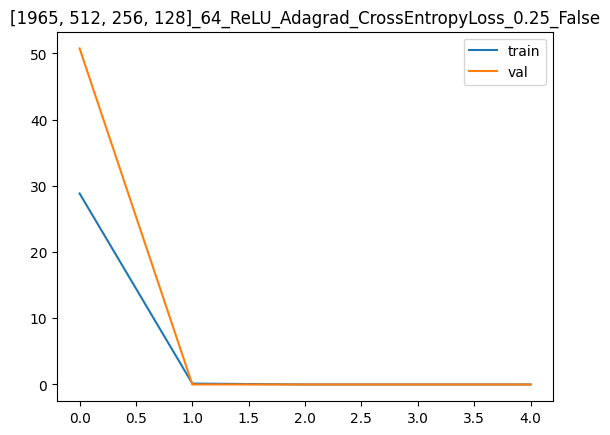

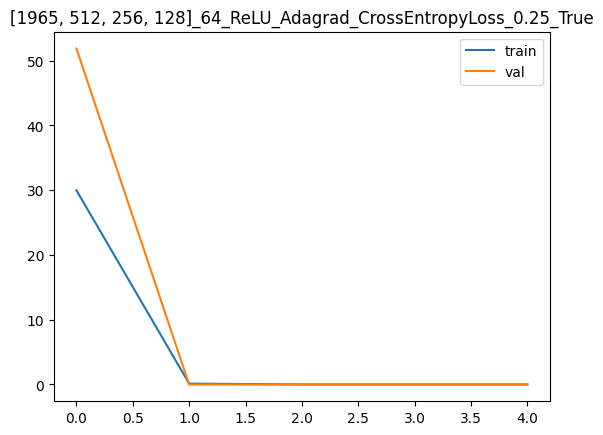

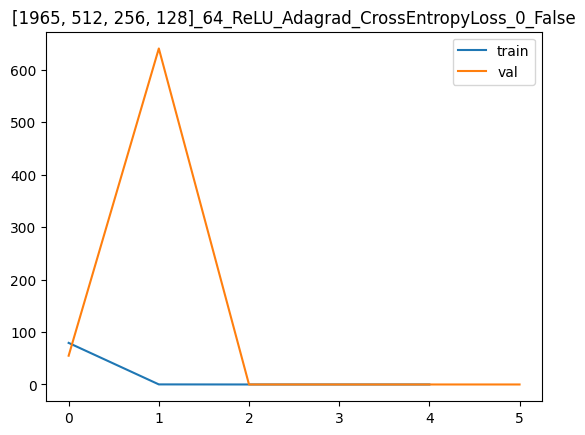

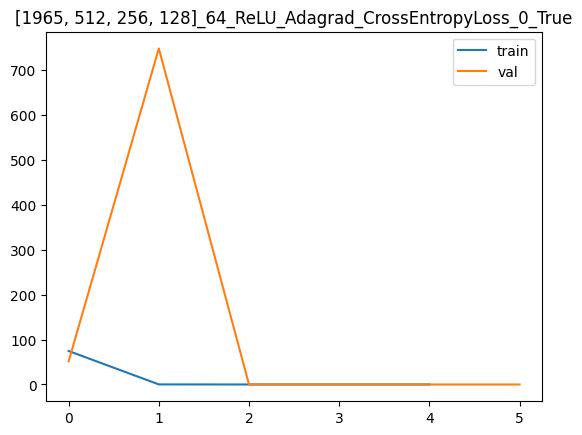

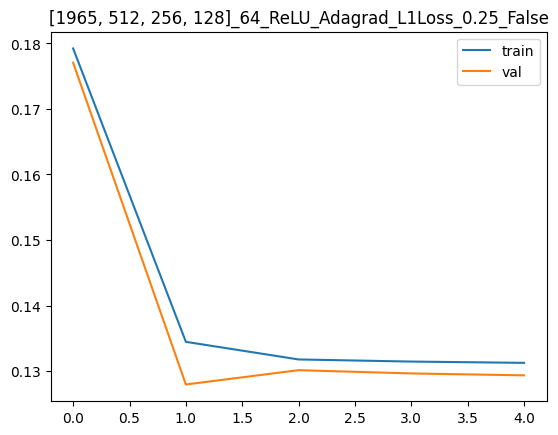

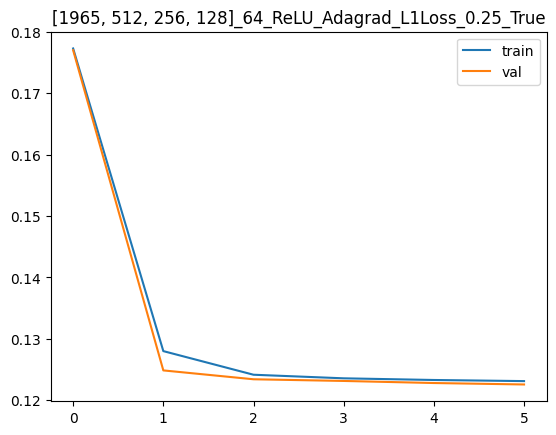

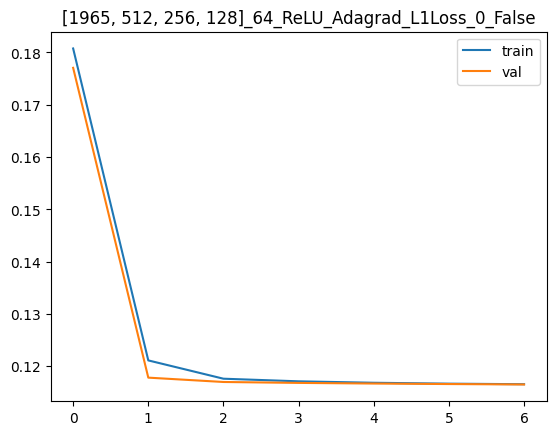

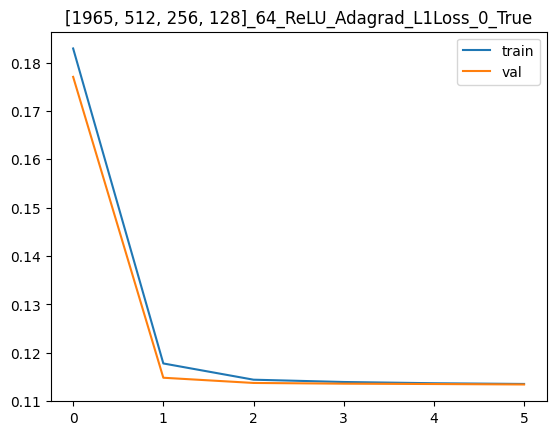

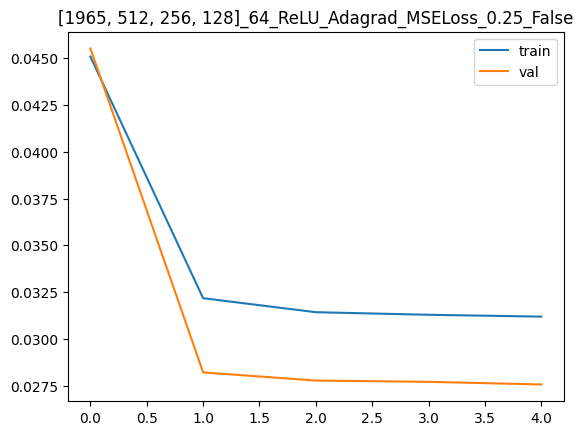

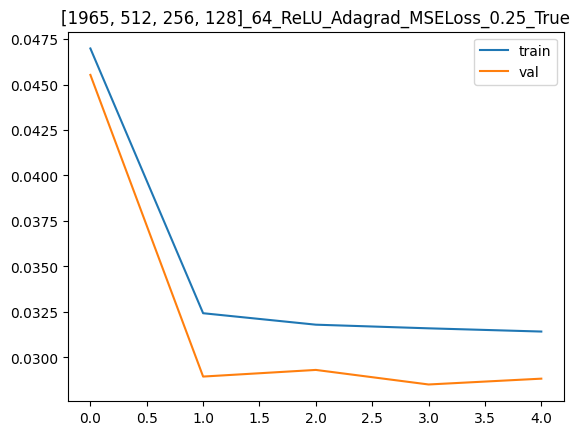

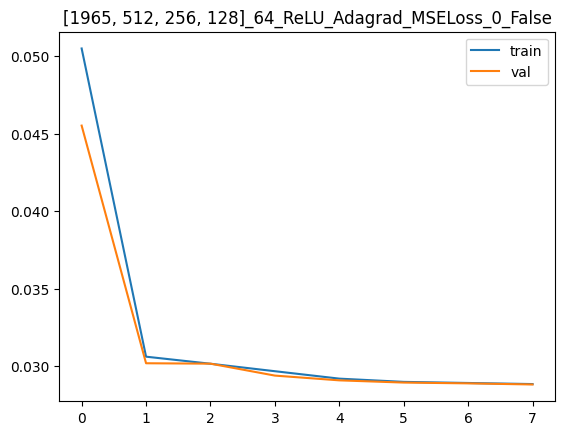

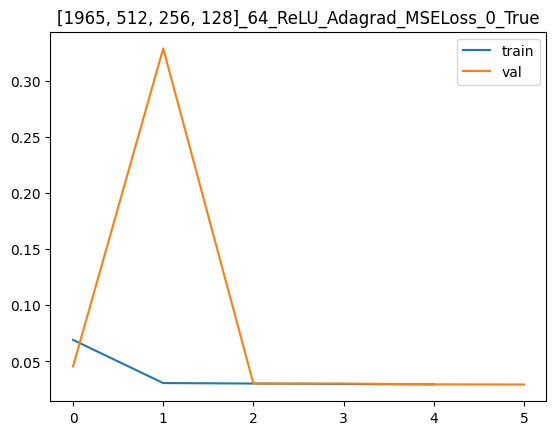

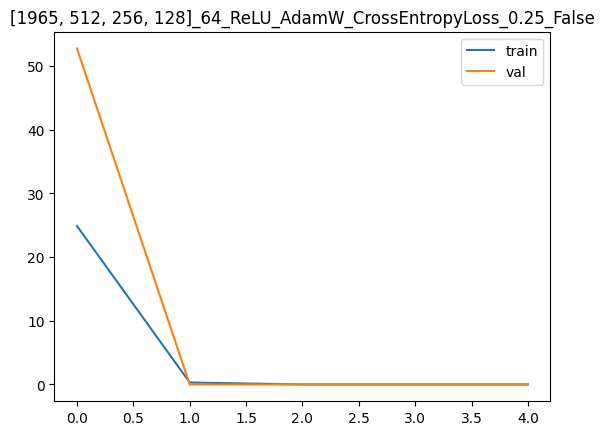

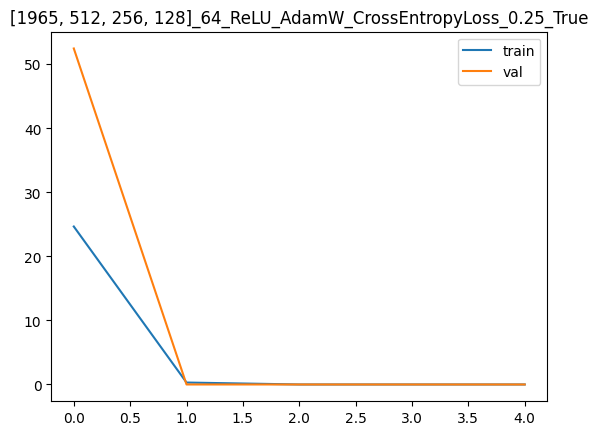

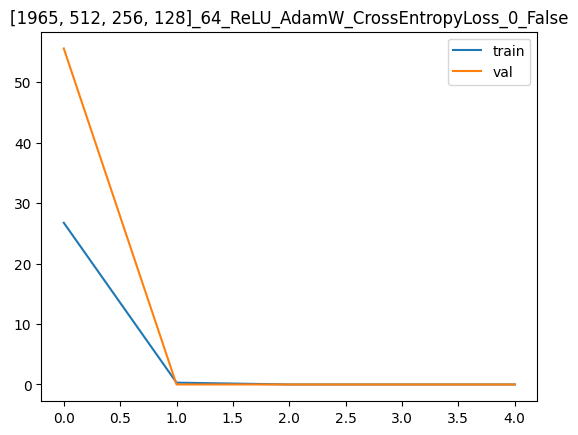

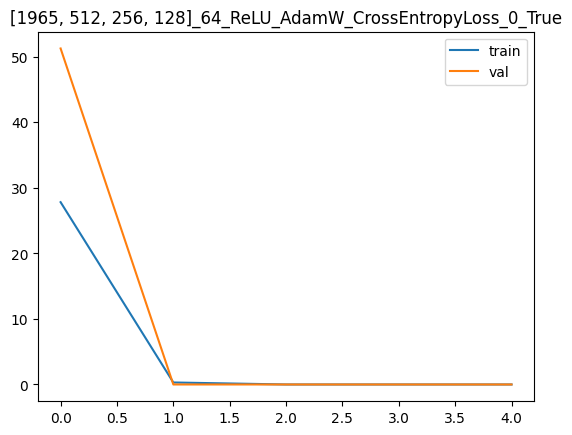

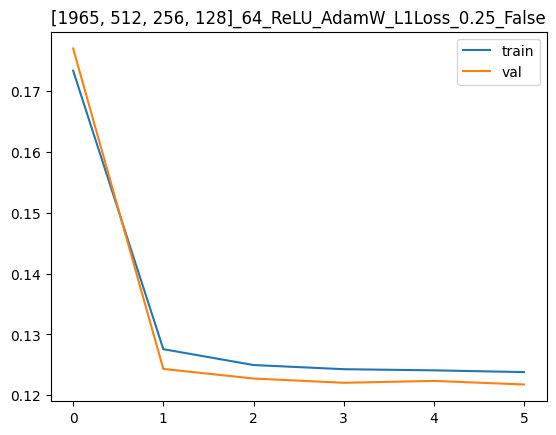

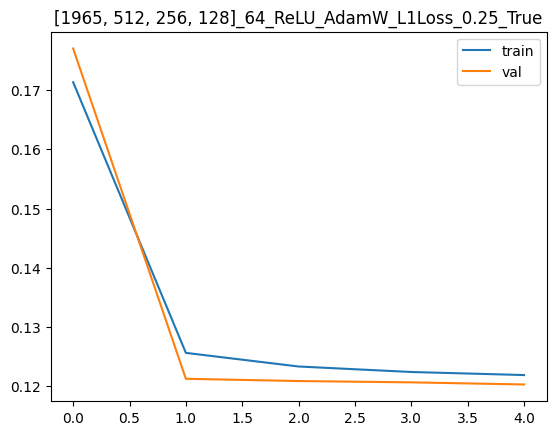

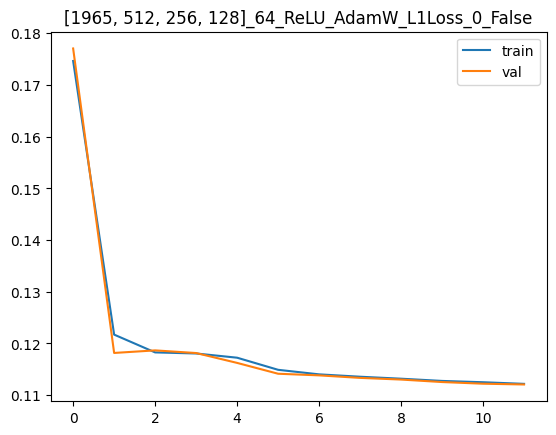

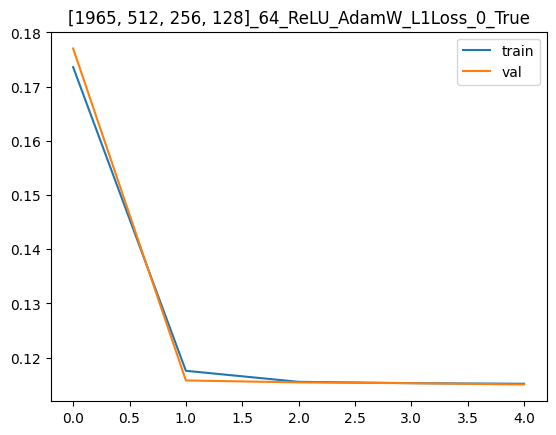

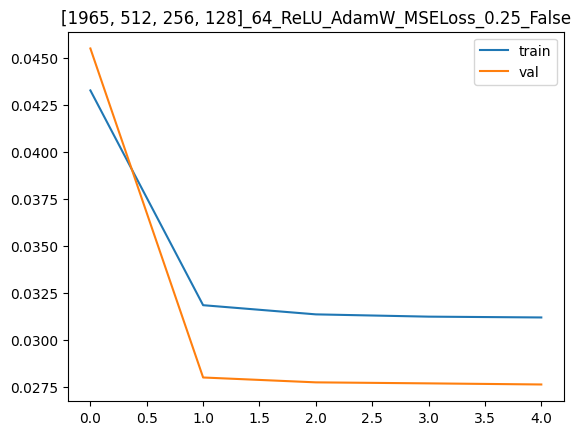

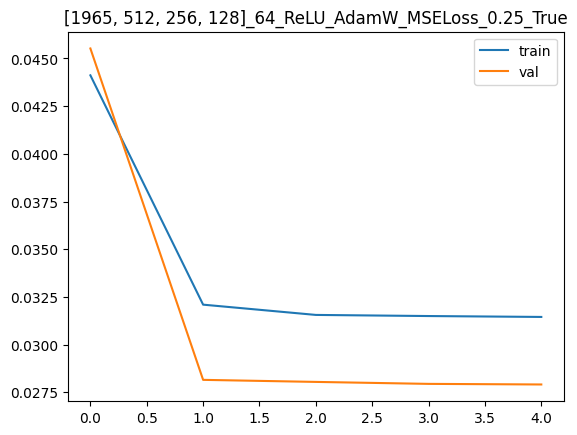

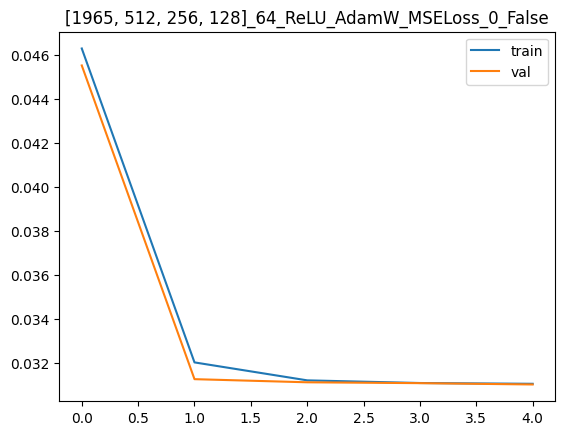

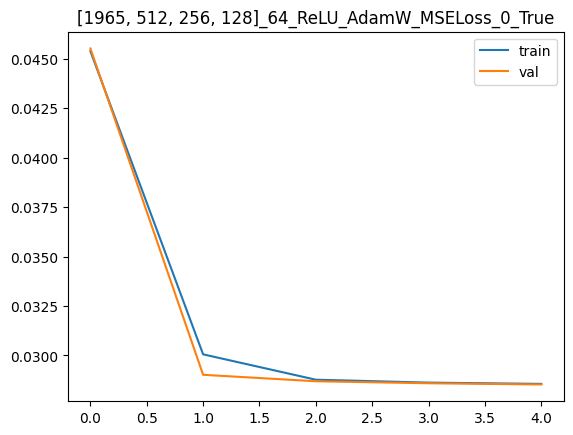

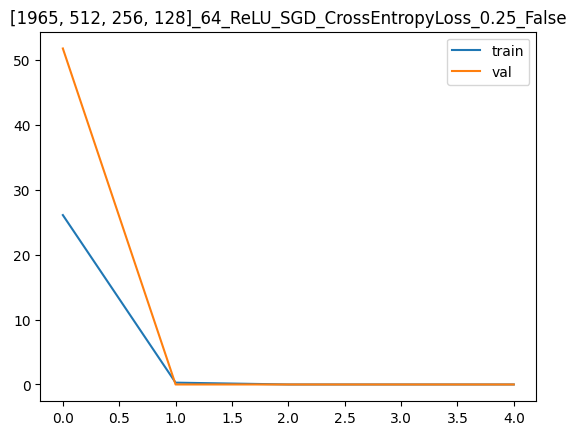

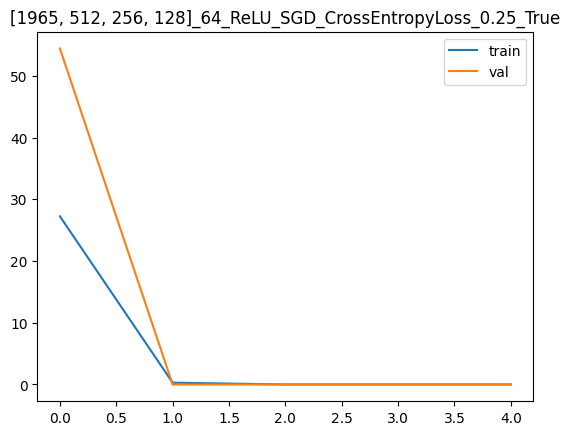

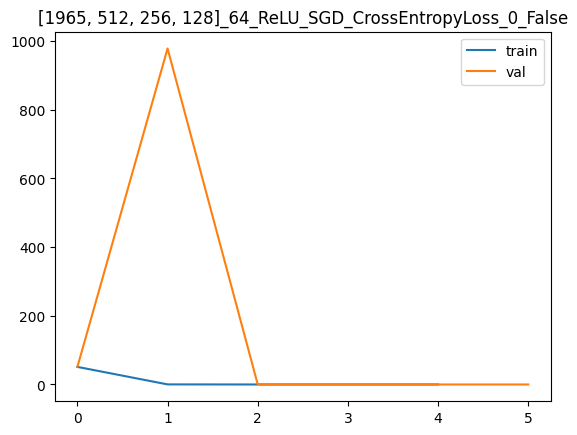

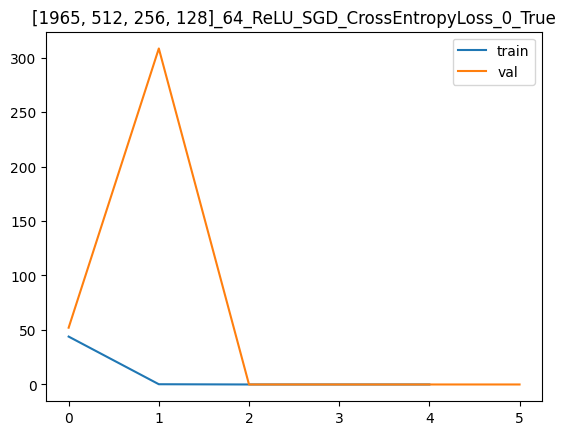

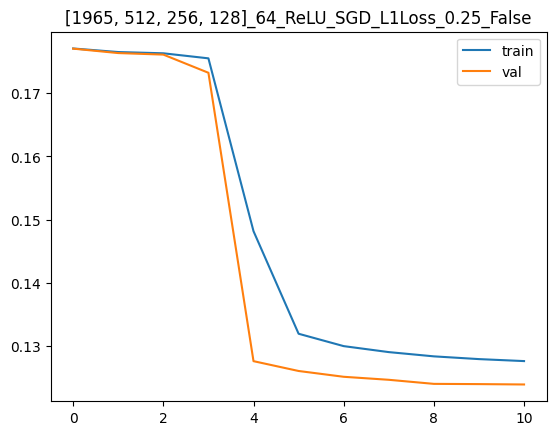

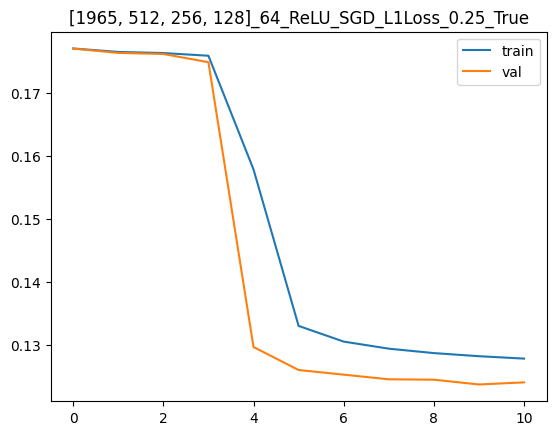

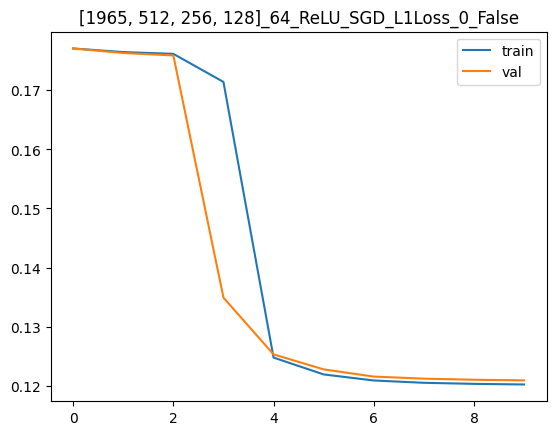

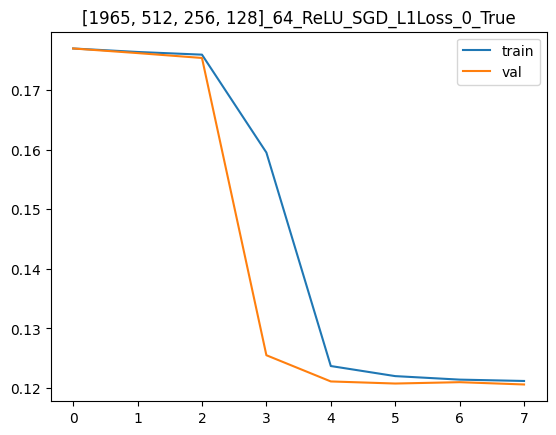

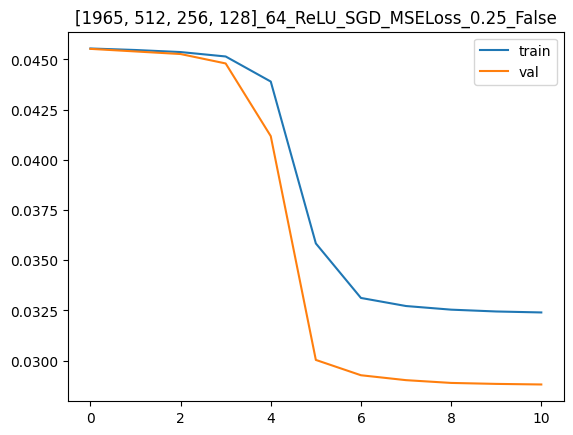

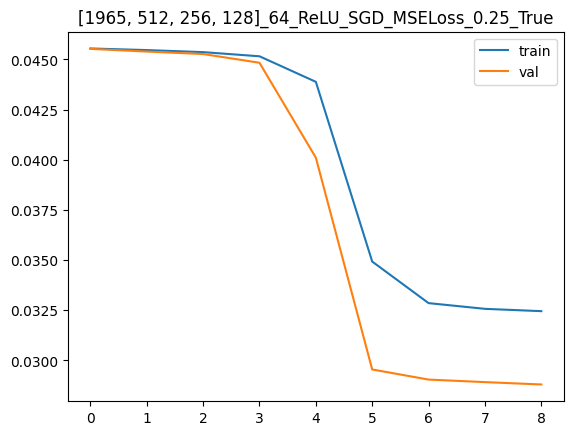

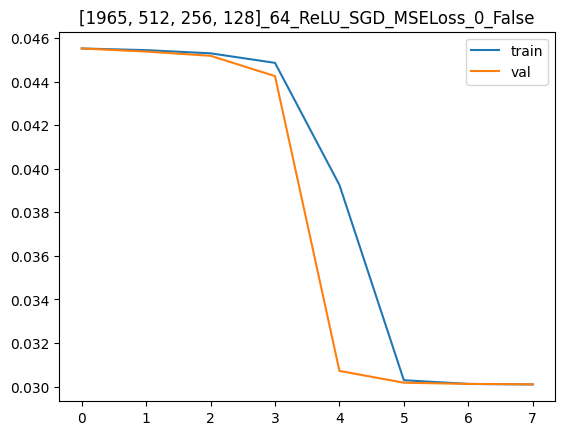

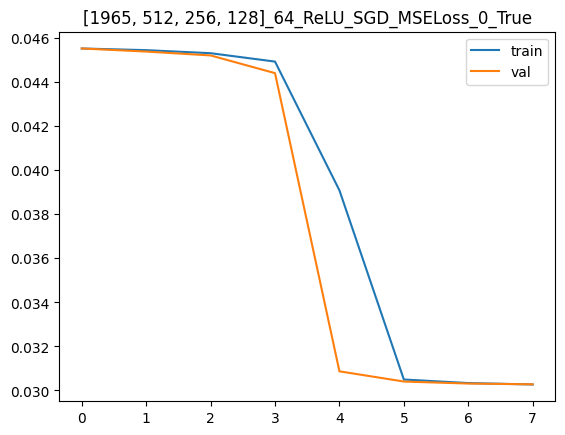

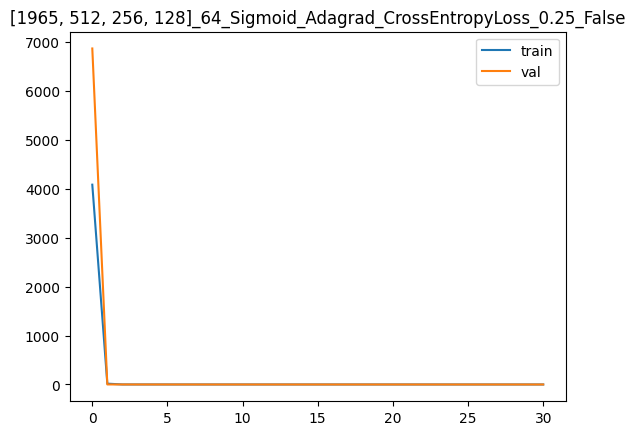

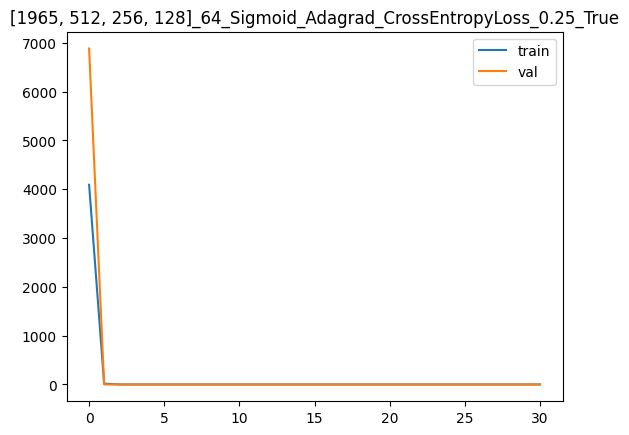

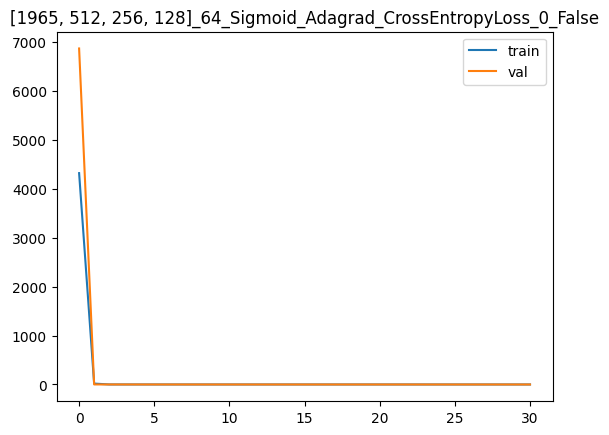

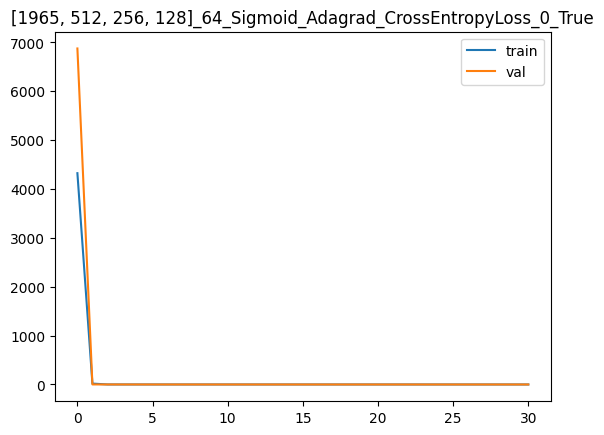

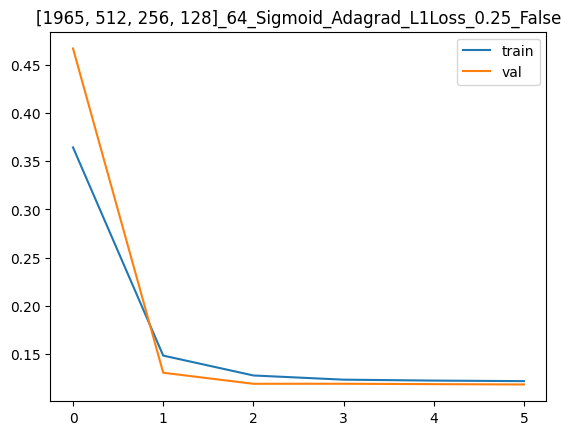

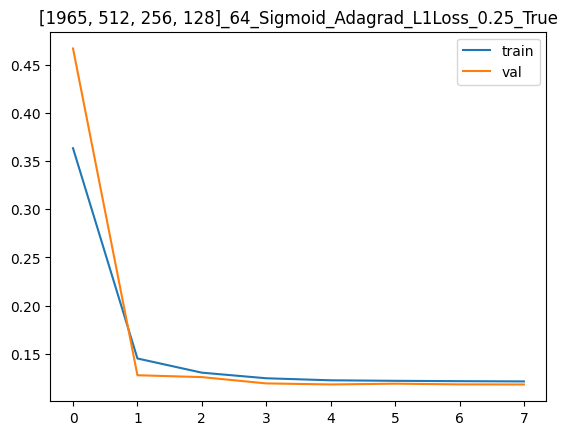

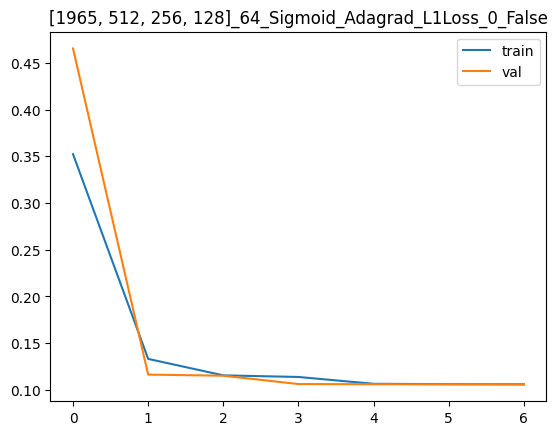

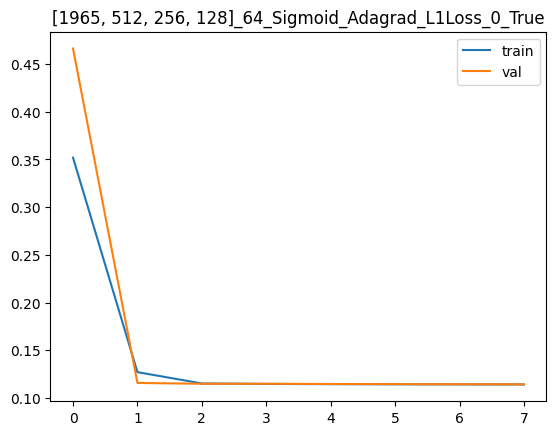

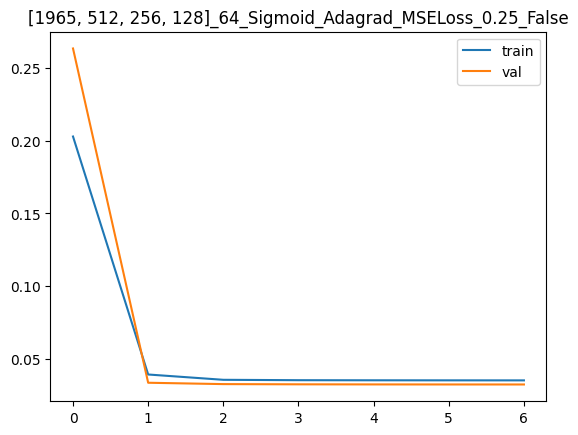

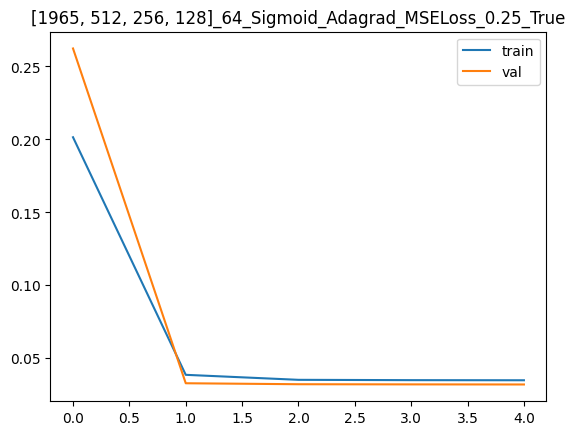

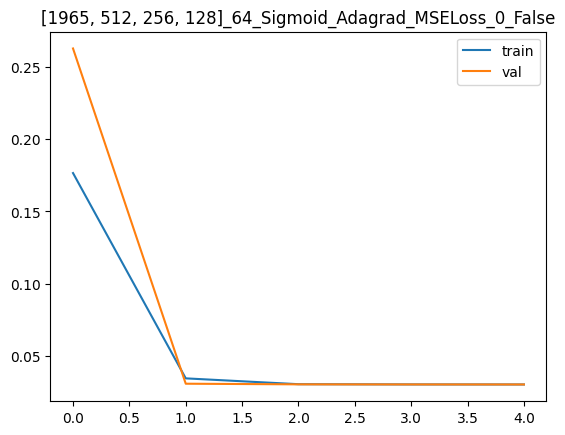

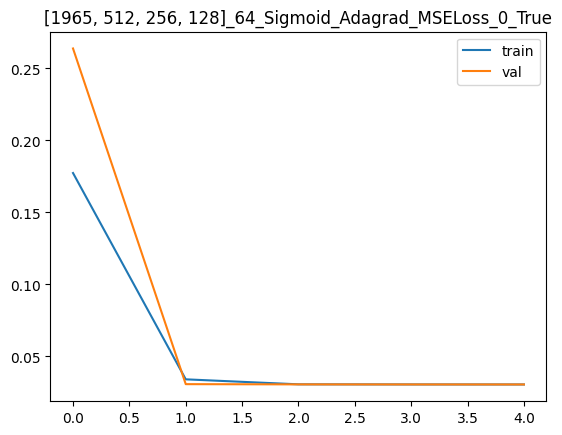

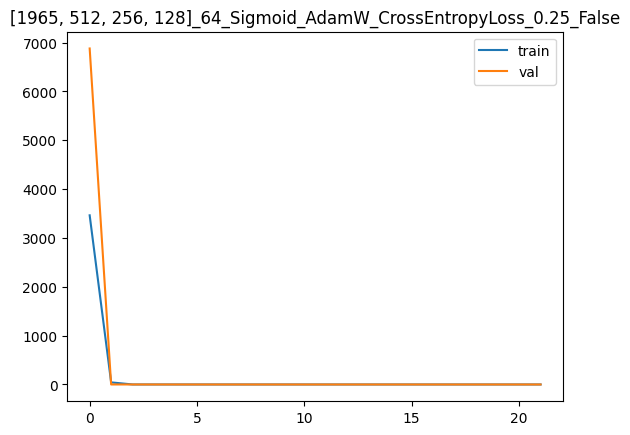

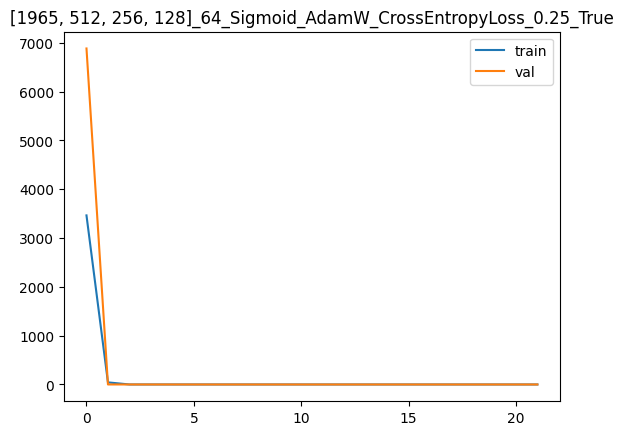

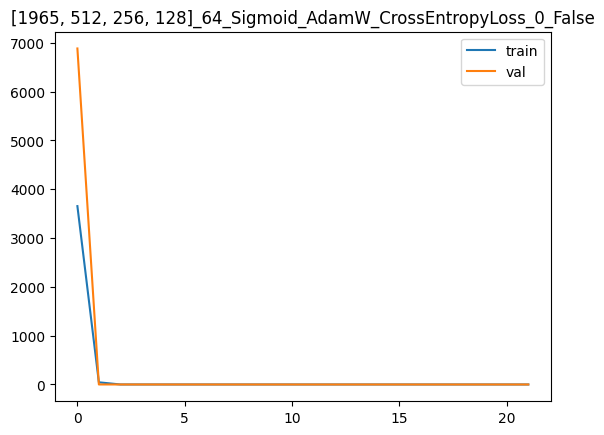

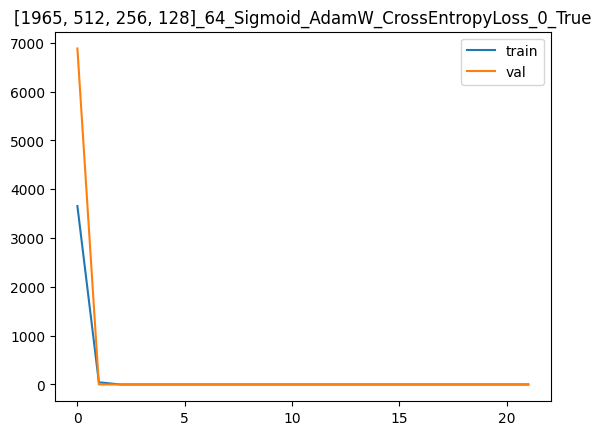

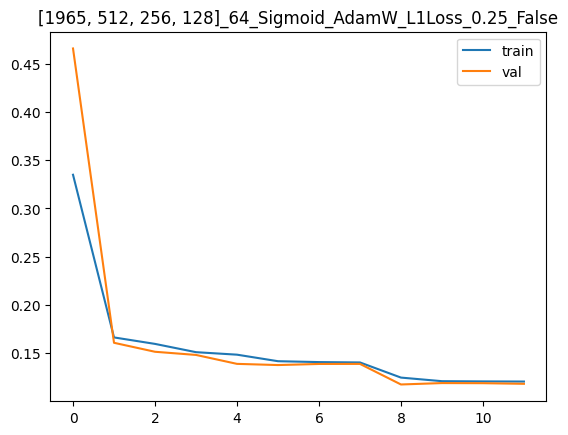

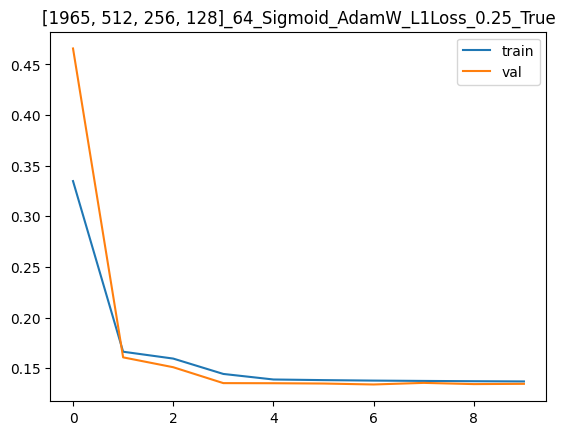

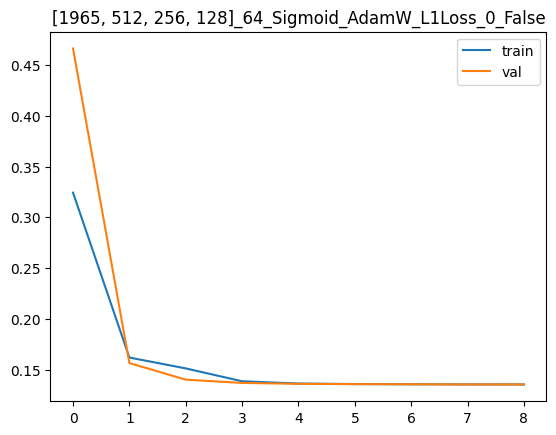

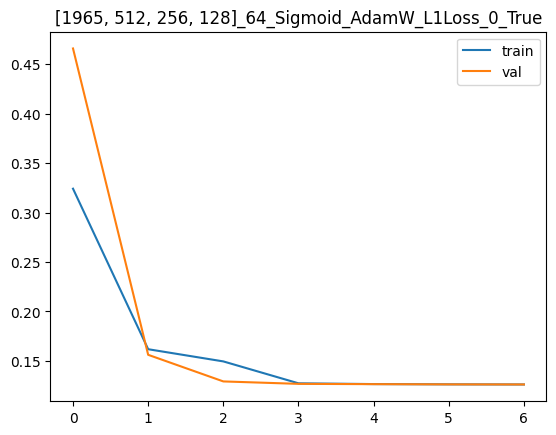

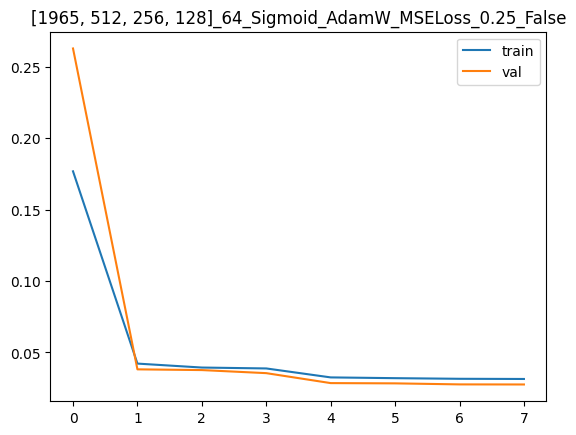

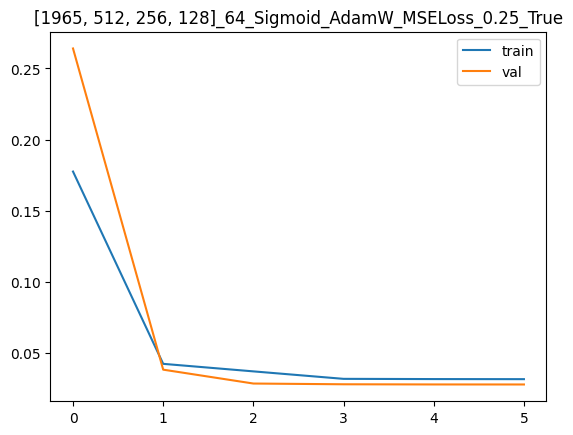

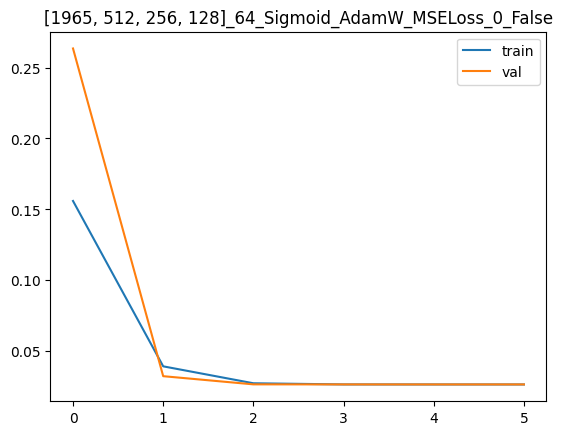

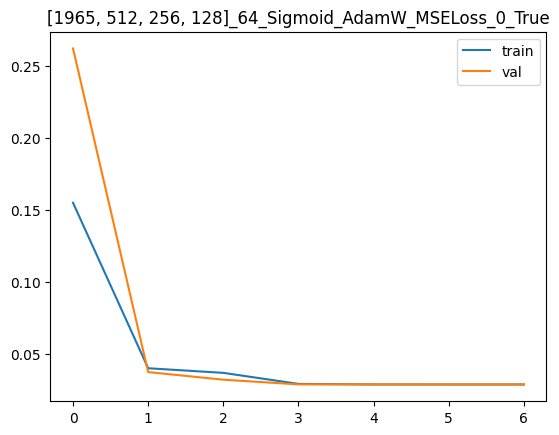

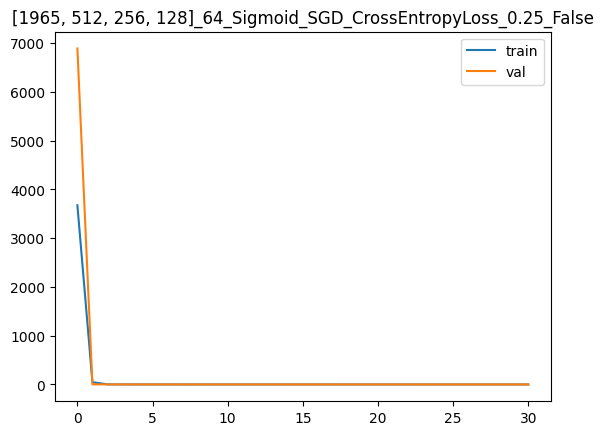

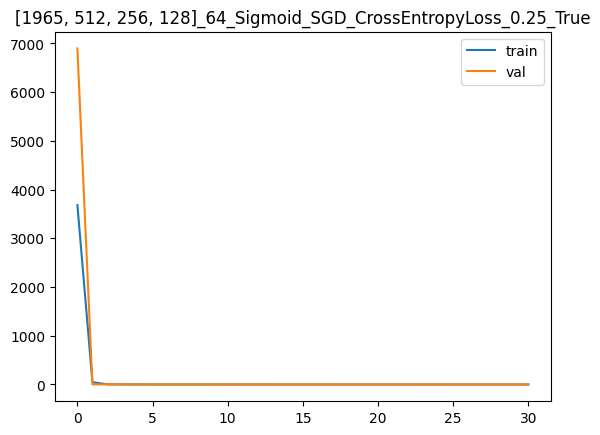

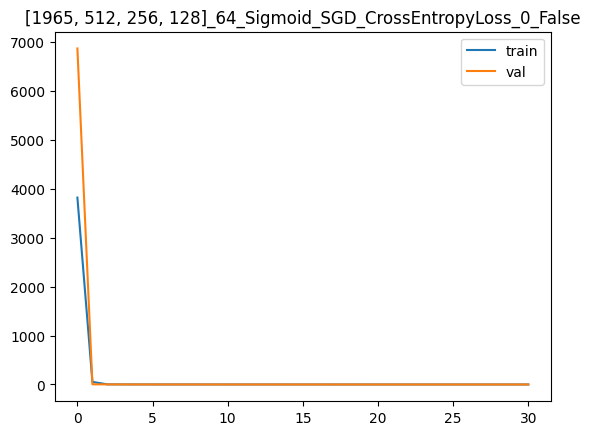

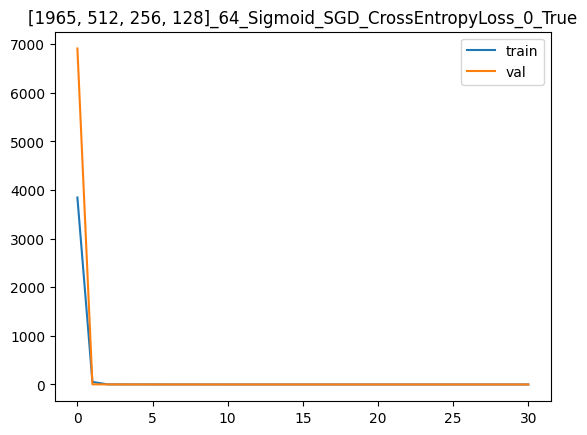

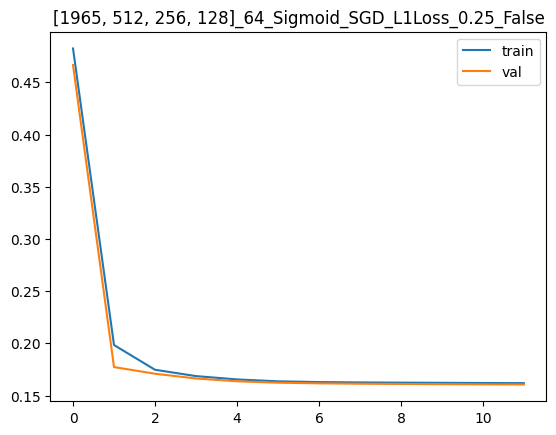

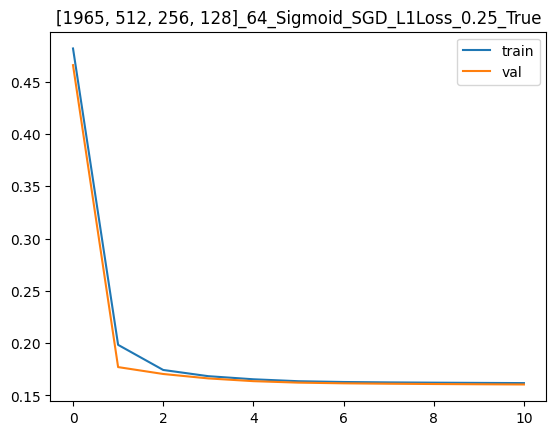

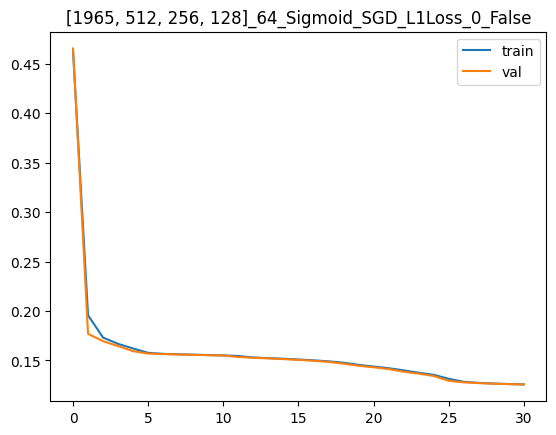

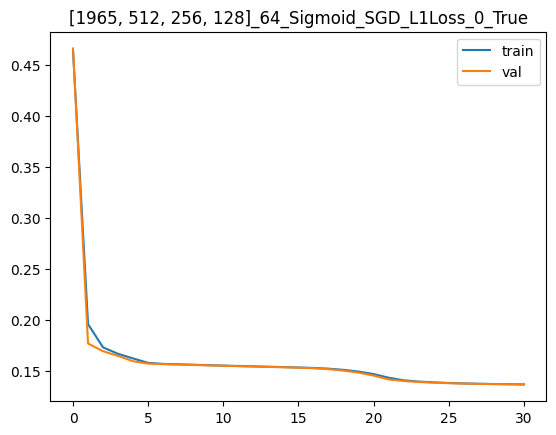

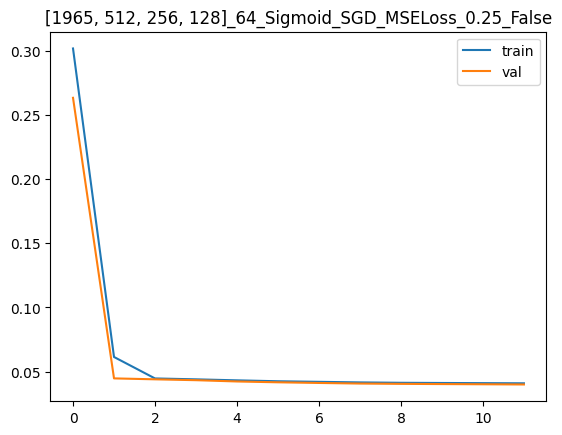

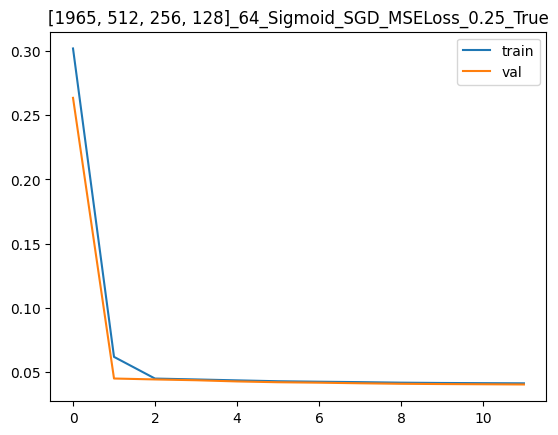

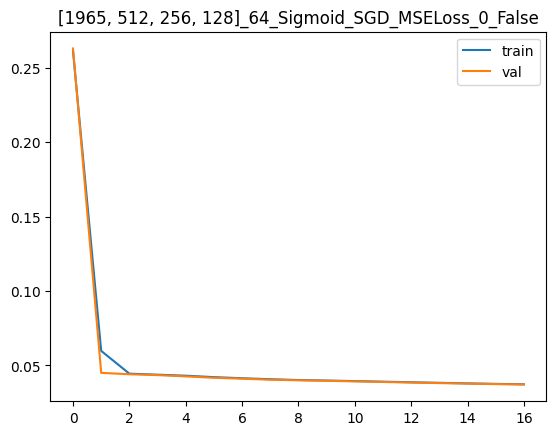

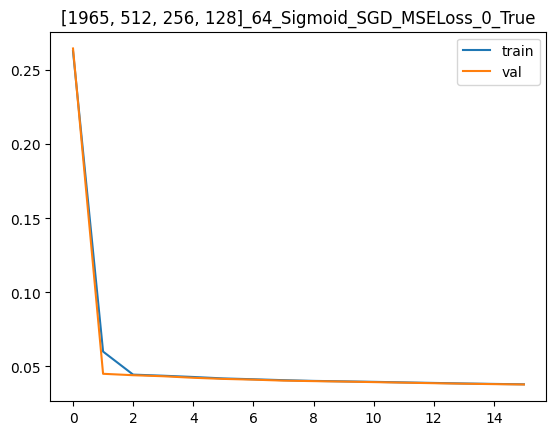

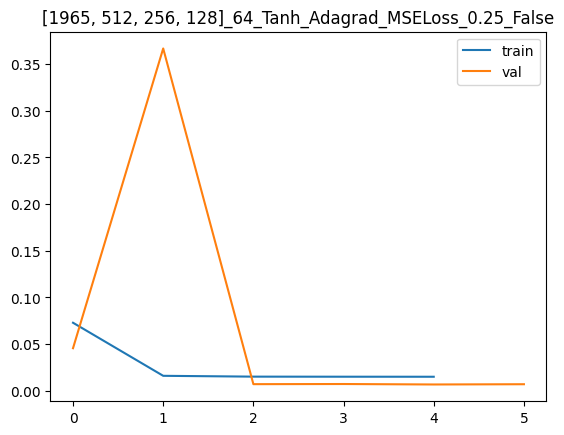

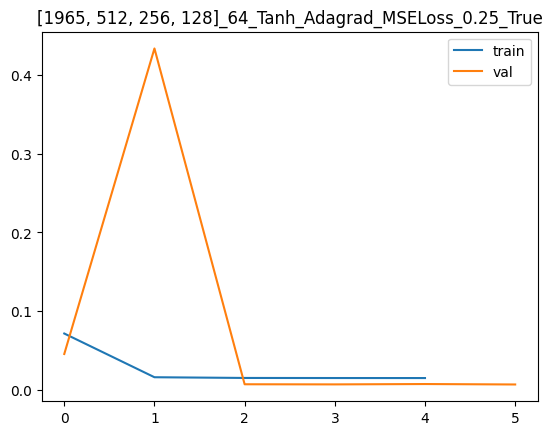

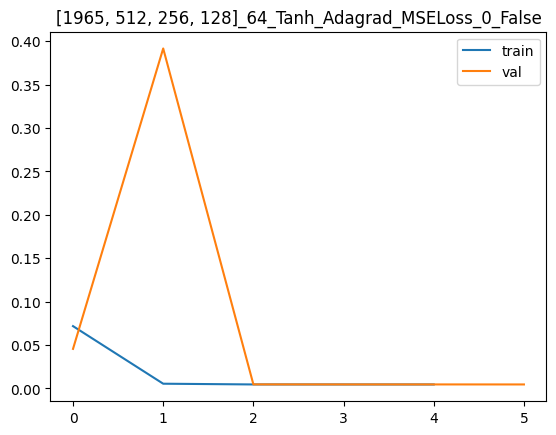

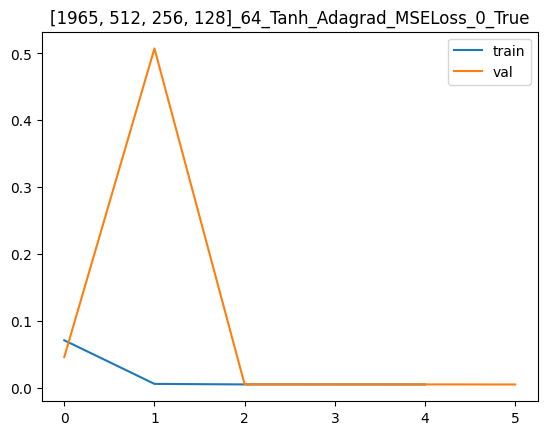

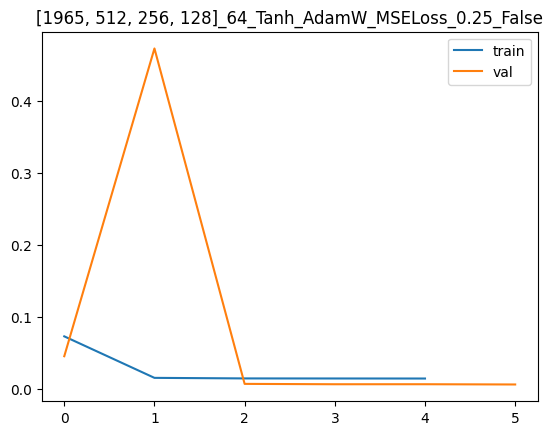

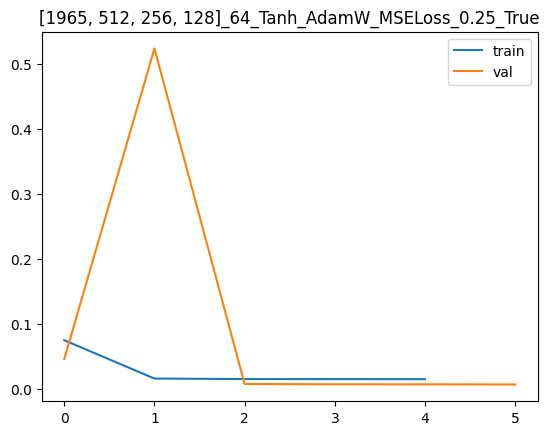

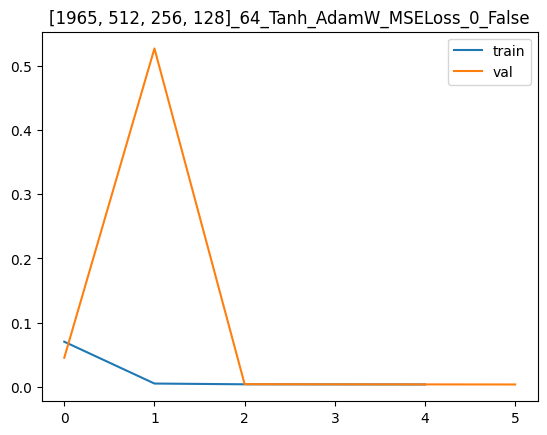

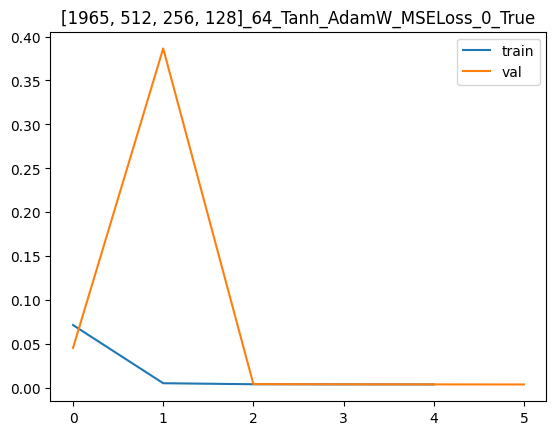

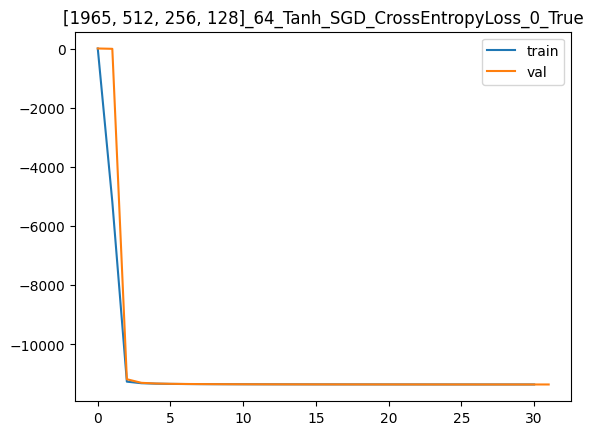

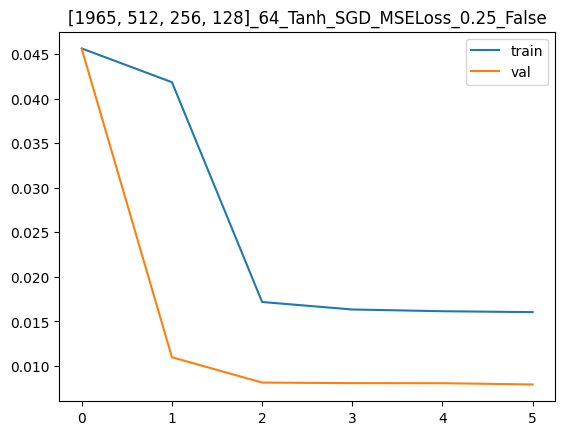

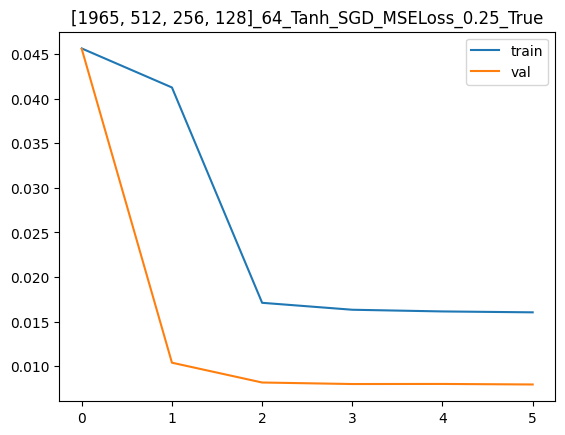

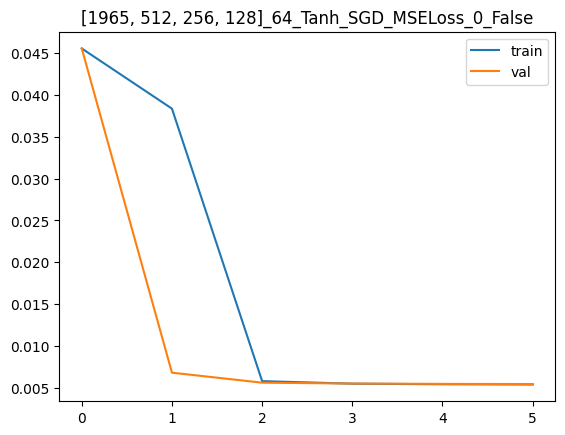

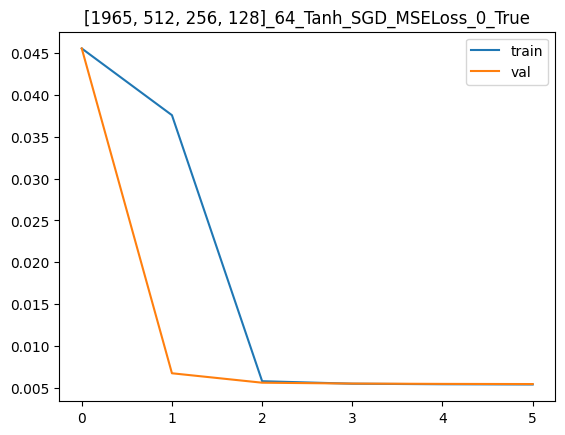

In [16]:
for name, model in models.items():
    plt.plot(range(len(model.training_epoch_mean)), model.training_epoch_mean, label='train')
    plt.plot(range(len(model.validation_epoch_mean)), model.validation_epoch_mean, label='val')
    
    np.mean([utils.correct_reconstrected_amino_acid(aa['sequence'], model(torch.Tensor(aa['emb']).unsqueeze(0).unsqueeze(0)).detach().cpu().numpy(), random_matrices) for aa in list(data.values())[:50]])
    plt.legend()
    plt.title(name)
    plt.show()